# Arqutecturas comunes:
### 1. Arquitecturas comunes
### 2. CIFAR-10
### 3. Una CNN sencilla
### 4. ResNet
### 5. Transfer learning
### 6. Fine-tuning

# Ejercicio: realiza un experimento similar al de transfer learning con aumento de datos
## Inicialización: librerías, semilla, lectura de CIFAR-10 y partición train-val-test

In [17]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; from keras import layers
keras.utils.set_random_seed(23)
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")
y_train_val = keras.utils.to_categorical(y_train_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


### Construcción del modelo: ResNet50V2 descabezada con entrada ajustada y nueva cabeza entrenable

In [18]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)
x = layers.Resizing(224, 224, interpolation="nearest")(x)
base_M = keras.applications.resnet_v2.ResNet50V2(include_top=False)
base_M.trainable = False
x = base_M(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units=800, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(10, activation='softmax')(x)
M = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#### Entrenamiento del modelo: guardamos el mejor modelo con un callback checkpoint

In [19]:
filename = 'CIFAR10_transfer_learning.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(x_train[:1000], y_train[:1000], batch_size=32, epochs=25, validation_data=(x_val, y_val), verbose=1,
callbacks=[checkpoint_cb, early_cb, reduce_cb])

Epoch 1/25


I0000 00:00:1733513079.886456   41414 service.cc:148] XLA service 0x7f9d44002210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733513079.886885   41414 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1733513080.830747   41414 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1302 - loss: 3.1572 

I0000 00:00:1733513087.923925   41414 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.4551 - loss: 1.9126
Epoch 1: val_accuracy improved from -inf to 0.79280, saving model to CIFAR10_transfer_learning.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 924ms/step - accuracy: 0.4596 - loss: 1.8955 - val_accuracy: 0.7928 - val_loss: 0.6238 - learning_rate: 0.0010
Epoch 2/25
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8572 - loss: 0.4216
Epoch 2: val_accuracy improved from 0.79280 to 0.81340, saving model to CIFAR10_transfer_learning.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step - accuracy: 0.8578 - loss: 0.4200 - val_accuracy: 0.8134 - val_loss: 0.5817 - learning_rate: 0.0010
Epoch 3/25
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9372 - loss: 0.2175
Epoch 3: val_accuracy did not improve from 0.81340
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.9370 - loss: 0.2171 - val_accuracy: 0.8055 - val_loss: 0.6048 - learning_rate: 0.0010
Epoch 4/25
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9652 - l

### Grafica y resultados

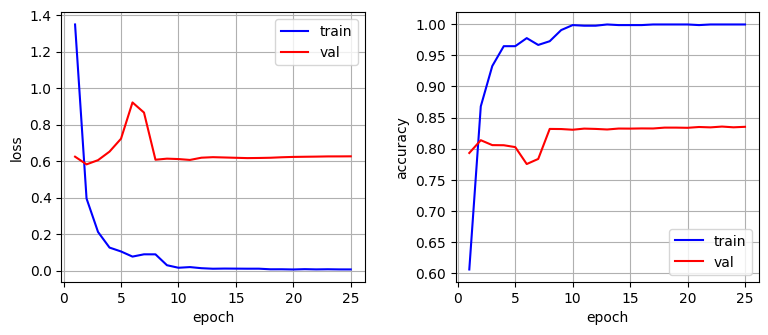

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5)); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); # ax.set_xticks(xx)
ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', label='train')
ax.plot(xx, H.history['val_loss'], color='r', label='val'); ax.legend()
ax = axes[1]; ax.grid(); # ax.set_xticks(xx)
ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', label='train')
ax.plot(xx, H.history['val_accuracy'], color='r', label='val'); ax.legend();

In [21]:
score = keras.models.load_model(filename).evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4} Precisión: {score[1]:.2%}')

Loss: 0.636 Precisión: 83.39%
